In [1]:
import pymongo
import pandas as pd
import numpy as np

from pymongo import MongoClient
from bson.objectid import ObjectId

import datetime

import matplotlib.pyplot as plt

from collections import defaultdict


%matplotlib inline
import json
plt.style.use('ggplot')

import seaborn as sns

from math import log10, floor

In [2]:
## Connect to local DB

client = MongoClient('localhost', 27017)
print ("Setup db access")

Setup db access


In [3]:
#
# Get collections from mongodb
#
#db = client.my_test_db
db = client.test


In [4]:
chunk = 100000
start = 0
end = start + chunk

In [5]:
reponses = db.anon_student_task_responses.find({'correct':False})[start:end]

In [6]:
df_responses = pd.DataFrame(list(reponses))

In [7]:
print (df_responses.head())

                        _id behavioral_traits  bonus  correct      diff  \
0  5a00f1739100de1a390000e7                []  False    False  0.284006   
1  5a00f1739100de1a390000ea                []  False    False  0.168491   
2  5a00f1739100de1a39000108                []  False    False  0.159949   
3  5a00f1739100de1a3900010d                []  False    False  0.569281   
4  5a00f1739100de1a39000128   [hops_vs_ticks]  False    False  0.000000   

           id  incomplete           lesson  \
0  39Y1vECA2c       False  review_lesson_4   
1  faYl5HT_Sn       False  review_lesson_4   
2  jGq7IGYWTF       False  review_lesson_1   
3  gM26ScOfQr       False  review_lesson_1   
4  iFYu9imr7r       False         nline_1a   

                                       level_summary  \
0  {'subject': 'review', 'unit_name': '', 'title'...   
1  {'subject': 'review', 'unit_name': '', 'title'...   
2  {'type': 'lesson', 't_elapsed': 193872, 'descr...   
3  {'type': 'lesson', 't_elapsed': 193872, 'desc

In [8]:
df_responses.shape

(100000, 27)

In [9]:
df2 = df_responses.join(pd.DataFrame(df_responses["student"].to_dict()).T)

In [10]:
df2 = df2.join(pd.DataFrame(df2['level_summary'].to_dict()).T)

In [11]:
df2 = df2.join(pd.DataFrame(df2['problems'].to_dict()).T)

In [12]:
df3  = df2.copy()

In [13]:
## Look act columns
print (df_responses.columns)

Index(['_id', 'behavioral_traits', 'bonus', 'correct', 'diff', 'id',
       'incomplete', 'lesson', 'level_summary', 'problem_set',
       'problem_set_id', 'problem_set_subspace', 'qual_id',
       'randomly_selected', 'response', 'response_idx', 'retried',
       'screenshot_url', 'second_try', 'session_id', 'student', 'sublesson',
       't', 'time_spent', 'timestamp', 'txt', 'untouched'],
      dtype='object')


In [14]:
## How many data samples
print (len(df_responses), "Number of entries")

100000 Number of entries


In [15]:
## Make 'description' a feature wih important words mapped

In [16]:
df3.columns

Index(['_id', 'behavioral_traits', 'bonus', 'correct', 'diff', 'id',
       'incomplete', 'lesson', 'level_summary', 'problem_set',
       'problem_set_id', 'problem_set_subspace', 'qual_id',
       'randomly_selected', 'response', 'response_idx', 'retried',
       'screenshot_url', 'second_try', 'session_id', 'student', 'sublesson',
       't', 'time_spent', 'timestamp', 'txt', 'untouched', 'grade',
       'mvt_group', 'mvt_group_code', 'school_id', 'section_id', 'student_id',
       'blank_slate_mastery', 'description', 'entered', 'lesson_type',
       'lm_stats', 'mastery', 'name', 'path', 'problems', 'stars', 'subject',
       't_elapsed', 'time_entered', 'time_exited', 'title', 'type',
       'unit_name', 'unit_rank', 'nretry_right', 'nretry_wrong', 'nright',
       'ntotal', 'nuntouched', 'nwrong'],
      dtype='object')

In [17]:
df3['percent_correct'] = df3['nright'].astype(float) / df3['ntotal']

In [18]:
df3.iloc[0]

_id                                              5a00f1739100de1a390000e7
behavioral_traits                                                      []
bonus                                                               False
correct                                                             False
diff                                                             0.284006
id                                                             39Y1vECA2c
incomplete                                                          False
lesson                                                    review_lesson_4
level_summary           {'subject': 'review', 'unit_name': '', 'title'...
problem_set             lessons/fractions/lesson10/quarters_ab/quarter...
problem_set_id                                                 BYGzN1ZApc
problem_set_subspace                                                 set2
qual_id                                        BYGzN1ZApc.set2.39Y1vECA2c
randomly_selected                     

In [19]:
for idx in range(100):
    print ('index"', idx)
    print (df3.iloc[idx]['lesson'])
    print (df3.iloc[idx]['response'])

index" 0
review_lesson_4
None
index" 1
review_lesson_4
None
index" 2
review_lesson_1
{'plain_image_groups': [{'total': 1, 'url': 'assets/cms/wootmath_fractions/number_line/objects/shark.swf'}, {'total': 1, 'url': 'assets/cms/wootmath_fractions/number_line/markers/start_marker.swf'}], 'fraction_cblock_containment': {}, 'input': '6', 'numberline_associations': [[{'position': 722, 'pos_value': 1.0028985507246377, 'obj_name': 'object', 'obj_value': None}]], 'fraction_cblock_chains': [{'sum': {'denominator': 1, 'numerator': 1, '__as3_type': 'Fraction'}, 'lcm_sum': {'denominator': 6, 'numerator': 6, '__as3_type': 'Fraction'}, 'pieces': ['1/6', '1/6', '1/6', '1/6', '1/6', '1/6'], 'left': 165, 'right': 856}], 'fraction_cblock_total_count': 6, 'fraction_cblock_counts': {'1/6': 6}}
index" 3
review_lesson_1
{'whole': '', 'fraction_input_value': '1/3', 'fraction_cblock_chains': [{'sum': {'denominator': 1, 'numerator': 1, '__as3_type': 'Fraction'}, 'lcm_sum': {'denominator': 3, 'numerator': 3, '__a

In [20]:
def stringify_response(resp):
    my_val = str(resp).replace("': ","_")
    my_val = my_val.replace("_{"," ")
    my_val = my_val.replace("_[",", ")
    for c in [']','[','{','}',"'","",","]:
        my_val = my_val.replace(c,'')
    return my_val


In [21]:
stringify_response(df3.iloc[0]['response'])

'None'

In [22]:
df3['response_str'] = df3['response'].apply(stringify_response)

In [23]:
for idx in range(20):
    print (idx, df3['response_str'].iloc[idx])

0 None
1 None
2 plain_image_groups total_1 url_assets/cms/wootmath_fractions/number_line/objects/shark.swf total_1 url_assets/cms/wootmath_fractions/number_line/markers/start_marker.swf fraction_cblock_containment  input_6 numberline_associations position_722 pos_value_1.0028985507246377 obj_name_object obj_value_None fraction_cblock_chains sum denominator_1 numerator_1 __as3_type_Fraction lcm_sum denominator_6 numerator_6 __as3_type_Fraction pieces 1/6 1/6 1/6 1/6 1/6 1/6 left_165 right_856 fraction_cblock_total_count_6 fraction_cblock_counts 1/6_6
3 whole_ fraction_input_value_1/3 fraction_cblock_chains sum denominator_1 numerator_1 __as3_type_Fraction lcm_sum denominator_3 numerator_3 __as3_type_Fraction pieces 1/3 1/3 1/3 left_96 right_657 fraction_cblock_containment  num_1 plain_image_groups total_1 url_assets/cms/wootmath_fractions/number_line/markers/end_marker.swf total_1 url_assets/cms/wootmath_fractions/number_line/markers/start_marker.swf total_1 url_assets/cms/wootmath_frac

In [24]:
df3.columns

Index(['_id', 'behavioral_traits', 'bonus', 'correct', 'diff', 'id',
       'incomplete', 'lesson', 'level_summary', 'problem_set',
       'problem_set_id', 'problem_set_subspace', 'qual_id',
       'randomly_selected', 'response', 'response_idx', 'retried',
       'screenshot_url', 'second_try', 'session_id', 'student', 'sublesson',
       't', 'time_spent', 'timestamp', 'txt', 'untouched', 'grade',
       'mvt_group', 'mvt_group_code', 'school_id', 'section_id', 'student_id',
       'blank_slate_mastery', 'description', 'entered', 'lesson_type',
       'lm_stats', 'mastery', 'name', 'path', 'problems', 'stars', 'subject',
       't_elapsed', 'time_entered', 'time_exited', 'title', 'type',
       'unit_name', 'unit_rank', 'nretry_right', 'nretry_wrong', 'nright',
       'ntotal', 'nuntouched', 'nwrong', 'percent_correct', 'response_str'],
      dtype='object')

In [25]:
## In Response:
### convert K, V, and all K_V into words in a text doc
### Then add text
### The add description


In [26]:
def make_string_from_list(key, elem_list):
    # Append key to each item in list
    ans = ''
    for elem in elem_list:
        ans += key + '_' + elem 
        
        

        
    

def make_string(elem, key=None, top=True):
    ans = ''
    if not elem:
        return ans
    if top:
        top = False
        top_keys = []
        for idx in range(len(elem.keys())):
            top_keys.append(True)
            
    for idx, key in enumerate(elem.keys()):
        if top_keys[idx]:
            top = True
            top_keys[idx] = False
            ans += ' '
        else:
            top = False
        #print ('ans = ', ans)
        #print (type(elem[key]))
        if type(elem[key]) is str or\
                type(elem[key]) is int:
            #print ('add value', elem[key])
            value = str(elem[key])
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        elif type(elem[key]) is list:
            #print ('add list', elem[key])
            temp_elem = dict()
            for item in elem[key]:
                temp_elem[key] = item
                ans += make_string(temp_elem, top) 
        elif type(elem[key]) is dict:
            #print ('add dict', elem[key])
            for item_key in elem[key].keys():
                temp_elem = dict()
                temp_elem[item_key] = elem[key][item_key]
                ans += key + '_' + make_string(temp_elem, top)
        elif type(elem[key]) is float:
            #print ('add dict', elem[key])
            sig = 2
            value = elem[key]
            value = round(value, sig-int(
            floor(log10(abs(value))))-1)
            value = str(value)
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        # ans += ' ' + key + ' '
        #print ('not handled', elem[key])
     
        
    return ans
        
            
            

In [27]:
df3['response_doc'] = df3['response'].map(make_string)

In [28]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')

In [29]:
df3['response_doc'] = df3['response_doc'] + df3['txt'] 

In [30]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')

In [31]:
df3['response_doc'] = df3['response_doc'] +  df3['description']

In [32]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("\n", ""))

In [33]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("?", " "))

In [34]:
df3.iloc[100]['response_doc']

'  plain_image_groups_ url_assets/cms/wootmath_fractions/number_line/objects_v2/shark_goggles.swf plain_image_groups_ total_1  plain_image_groups_ url_assets/cms/wootmath_fractions/number_line/markers/start_marker.swf plain_image_groups_ total_1  input_11    numberline_associations_ position_570.0 numberline_associations_ numberline_associations_ obj_name_object numberline_associations_ pos_value_0.71  The shark swam 5 tenths of a mile from the start, and thenswam back 2 tenths of a mile. Drag the shark to its final location.Answer: 3/10 A review of material from earlier lessons. The following topics were selected for review: Labeling Tenths on the Number Line; Locating Tenths on the Number Line; and Composing Decimals on the Number Line'

In [35]:
df3.iloc[100]['response']

{'input': '11',
 'numberline_associations': [[{'obj_name': 'object',
    'obj_value': None,
    'pos_value': 0.7128229702353126,
    'position': 572.5612903225807}]],
 'plain_image_groups': [{'total': 1,
   'url': 'assets/cms/wootmath_fractions/number_line/objects_v2/shark_goggles.swf'},
  {'total': 1,
   'url': 'assets/cms/wootmath_fractions/number_line/markers/start_marker.swf'}]}

In [36]:
for idx in range(20):
    print (idx, df3['response_doc'].iloc[idx])

0  Shade 1/4 of the circle.answer={:n=>3, :d=>12} A review of material from earlier lessons. The following topics were selected for review: One Fourth of Shapes and Sets - Supplemental 1; One Fourth of Shapes and Sets; and Equivalent Fractions in Partitioning Sets.
1  Shade 1/3 of the rectangle.answer={:n=>2, :d=>6} A review of material from earlier lessons. The following topics were selected for review: One Third of Shapes and Sets; One Fourth of Shapes and Sets; and Equivalent Fractions in Partitioning Sets.
2   plain_image_groups_ total_1 plain_image_groups_ url_assets/cms/wootmath_fractions/number_line/objects/shark.swf  plain_image_groups_ total_1 plain_image_groups_ url_assets/cms/wootmath_fractions/number_line/markers/start_marker.swf   input_6    numberline_associations_ position_722 numberline_associations_ pos_value_1.0 numberline_associations_ obj_name_object numberline_associations_   fraction_cblock_chains_ sum_ denominator_1 sum_ numerator_1 sum_ __as3_type_Fraction fract

In [37]:
df3['response_doc'] = df3['response_doc'].map( lambda x: " ".join(x.split('/')) if '/' in x else x)

In [38]:
df3.iloc[100]['response_doc']

'  plain_image_groups_ url_assets cms wootmath_fractions number_line objects_v2 shark_goggles.swf plain_image_groups_ total_1  plain_image_groups_ url_assets cms wootmath_fractions number_line markers start_marker.swf plain_image_groups_ total_1  input_11    numberline_associations_ position_570.0 numberline_associations_ numberline_associations_ obj_name_object numberline_associations_ pos_value_0.71  The shark swam 5 tenths of a mile from the start, and thenswam back 2 tenths of a mile. Drag the shark to its final location.Answer: 3 10 A review of material from earlier lessons. The following topics were selected for review: Labeling Tenths on the Number Line; Locating Tenths on the Number Line; and Composing Decimals on the Number Line'

In [39]:
df3['response_doc'] = df3['response_doc'].map( lambda x: x.replace('[',' '))
df3['response_doc'] = df3['response_doc'].map( lambda x: x.replace(']',' '))

In [40]:
df3.iloc[100]['response_doc']

'  plain_image_groups_ url_assets cms wootmath_fractions number_line objects_v2 shark_goggles.swf plain_image_groups_ total_1  plain_image_groups_ url_assets cms wootmath_fractions number_line markers start_marker.swf plain_image_groups_ total_1  input_11    numberline_associations_ position_570.0 numberline_associations_ numberline_associations_ obj_name_object numberline_associations_ pos_value_0.71  The shark swam 5 tenths of a mile from the start, and thenswam back 2 tenths of a mile. Drag the shark to its final location.Answer: 3 10 A review of material from earlier lessons. The following topics were selected for review: Labeling Tenths on the Number Line; Locating Tenths on the Number Line; and Composing Decimals on the Number Line'

In [41]:
docs = list(df3['response_doc'])

In [42]:
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [43]:
data_samples = docs

In [44]:
n_features = 1000
n_samples = len(data_samples)
n_topics = 50
n_top_words = 20

In [45]:
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

Extracting tf-idf features for NMF...


In [46]:
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


done in 10.364s.


In [47]:
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


Extracting tf features for LDA...
done in 9.615s.


In [48]:
n_features = 1000
n_samples = len(data_samples)
n_topics = 50
n_top_words = 20

In [49]:
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


Extracting tf-idf features for NMF...
done in 10.769s.
Extracting tf features for LDA...
done in 10.923s.


In [50]:

from sklearn.cluster import KMeans, MiniBatchKMeans
true_k = 100

km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000)

In [51]:
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(tf)
print("done in %0.3fs" % (time() - t0))
print()

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=1, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)
done in 1.823s



In [52]:
print("Top terms per cluster:")


order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tf_vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0: pieces_1 fraction_circle_groups_ lcm_sum_ sum_ chains_ __as3_type_fraction scale_0 fraction_circle_containment_ numerator_1 unit1_
Cluster 1: fraction_cblock_chains_ sum_ lcm_sum_ pieces_1 __as3_type_fraction numberline_associations_ numerator_1 number line answer
Cluster 2: fraction_cblock_chains_ sum_ lcm_sum_ __as3_type_fraction numerator_1 pieces_1 denominator_1 fraction_cblock_counts_ denominator_4 left_175
Cluster 3: fraction_cblock_chains_ sum_ lcm_sum_ pieces_1 __as3_type_fraction numerator_1 fraction denominator_1 1_ fraction_cblock_counts_
Cluster 4: numberline_associations_ plain_image_groups_ wootmath_fractions url_assets total_1 swf cms number_line number line
Cluster 5: form simplest represent fractions sets ladybugs objects enter use students
Cluster 6: pieces_1 12 fraction_circle_groups_ sum_ lcm_sum_ chains_ __as3_type_fraction fraction_circle_counts_ fraction numerator_1
Cluster 7: pieces_1 12 fraction_circle_groups_ answer denominato

In [53]:
len(km.labels_)

100000

In [54]:
np.bincount(km.labels_)

array([  388,  1056,   894,   887,  2799,    29,   384,    47,   988,
        2274,   439,   422,   190,  1054,   772,   482,     2,  2179,
         911,   505,   502,   431,  1038,   276,   210,   292,   439,
         279,    72,   621,   238,  1093,   902,   211,   255,   810,
         607,  2857,  4730,   496,   241,  1376,   208,   890,  1278,
        3002,   282,   212,   746,   819,  6687,   511,  1204,     0,
          18,   280,     4,   303,   703,    13,   606,  2493,   374,
         294,   867,   281, 13852,  3079,   275,   618,  1547,  1583,
         194,   236,   246,  1213,  1894,  1547,    14,  2565,   866,
         882,   759,    56,   324,   444,  1305,  2521,   657,   204,
         283,  1252,   332,   435,   445,  1881,   600,   389,   429,   320])

In [55]:
df3['cluster_100'] = km.labels_

In [56]:
len(np.bincount(km.labels_))

100

In [57]:
df3['cluster_100'] = km.labels_


In [58]:
df3['trait_1'] = df3['behavioral_traits'].apply(lambda x : x[0] if len(x) > 0 else 'None' )

In [59]:
df3['trait_2'] = df3['behavioral_traits'].apply(lambda x : x[1] if len(x) > 1 else 'None' ) 

In [60]:
df3['trait_1'].value_counts()

None                             66277
inverts_numerator_denominator     5651
how_to_model                      4082
identifying_gt_lt                 3703
starting_from_0_nline             1782
counting_hops_not_ticks           1622
recognizing_the_whole             1371
deci_incorrect_inequality         1339
deci_understanding_gt_lt          1317
inequality_symbol                 1240
partially_drawn_parts             1132
dragging_to_add                    871
modeled_incorrect_comparison       837
partitioning_number_line           804
simplifying_bars_2                 790
deci_placing_decimal_points        595
misplaced_fraction_part_nline      538
simplifying_subtraction            523
measuring_tools                    517
hops_vs_ticks                      501
comparing_frac_gt_lt               473
only_tenths_entered                418
fraction_of_set                    371
multiplying_whole_by_proper        361
deci_forgot_decimal_point          291
simplify_with_common_deno

In [61]:
df3['trait_2'].value_counts()

None                            94762
equally_sized_parts              1132
modeled_incorrect_numerator       837
wrong_number_parts                804
simplifying_mixed_numbers         798
orange_tick                       517
simplifying_answers_nline         512
dragging_to_add_3_circles         262
nline_restart_one                 192
deci_break_tenths_hundredths      175
modulo_ans                          9
Name: trait_2, dtype: int64

In [62]:
df_cluster_100 = df3.groupby('cluster_100')

In [63]:
len(df_cluster_100)

99

In [64]:
df_cluster_100.head()

,_id,behavioral_traits,bonus,correct,diff,id,incomplete,lesson,level_summary,problem_set,...,nright,ntotal,nuntouched,nwrong,percent_correct,response_str,response_doc,cluster_100,trait_1,trait_2
0,5a00f1739100de1a390000e7,[],False,False,0.284006,39Y1vECA2c,False,review_lesson_4,"{'subject': 'review', 'unit_name': '', 'title'...",lessons/fractions/lesson10/quarters_ab/quarter...,...,1,4,1,3,0.250000,None,"Shade 1 4 of the circle.answer={:n=>3, :d=>12...",66,None,None
1,5a00f1739100de1a390000ea,[],False,False,0.168491,faYl5HT_Sn,False,review_lesson_4,"{'subject': 'review', 'unit_name': '', 'title'...",lessons/fractions/lesson11/thirds/media/proble...,...,0,3,4,3,0.000000,None,"Shade 1 3 of the rectangle.answer={:n=>2, :d=...",66,None,None
2,5a00f1739100de1a39000108,[],False,False,0.159949,jGq7IGYWTF,False,review_lesson_1,"{'type': 'lesson', 't_elapsed': 193872, 'descr...",lessons/fractions/lesson13_1/part_b/media/prob...,...,3,6,0,3,0.500000,plain_image_groups total_1 url_assets/cms/woot...,plain_image_groups_ total_1 plain_image_grou...,1,None,None
3,5a00f1739100de1a3900010d,[],False,False,0.569281,gM26ScOfQr,False,review_lesson_1,"{'type': 'lesson', 't_elapsed': 193872, 'descr...",lessons/fractions/lesson13_1/part_a/media/prob...,...,3,6,0,3,0.500000,whole_ fraction_input_value_1/3 fraction_cbloc...,whole_ fraction_input_value_1 3 fraction_c...,70,None,None
4,5a00f1739100de1a39000128,[hops_vs_ticks],False,False,0.000000,iFYu9imr7r,False,nline_1a,"{'type': 'lesson', 'mastery': {'mean': 0.02477...",lessons/fractions/lesson13_3/part_a/media/prob...,...,10,14,0,4,0.714286,num_1 fraction_input_value_Fraction 1 numberli...,num_1 fraction_input_value_ Fraction 1 w...,39,hops_vs_ticks,None
5,5a00f1739100de1a39000130,"[partitioning_number_line, wrong_number_parts]",False,False,0.105381,RpNOh3tBju,True,nline_1a,"{'type': 'lesson', 'mastery': {'mean': 0.02477...",lessons/fractions/lesson13_3/part_b/media/prob...,...,10,14,0,4,0.714286,whole_ fraction_input_value_Fraction 1 den_inp...,whole_ fraction_input_value_ Fraction 1 de...,39,partitioning_number_line,wrong_number_parts
6,5a00f1739100de1a39000133,"[partitioning_number_line, wrong_number_parts]",False,False,0.277946,rhkFQkJo1i,False,nline_1a,"{'type': 'lesson', 'mastery': {'mean': 0.02477...",lessons/fractions/lesson13_3/part_b/media/prob...,...,10,14,0,4,0.714286,whole_ fraction_input_value_Fraction 1 den_inp...,whole_ fraction_input_value_ Fraction 1 de...,39,partitioning_number_line,wrong_number_parts
7,5a00f1739100de1a39000192,[],True,False,1.000000,YW-9tGkI85,False,simplify_1,{'title': 'Fractions in Simplest Form with Mod...,lessons/fractions/lesson41/bonus/media/problem...,...,4,5,0,1,0.800000,fraction_cblock_counts 1_1 1/4_3 fraction_cblo...,fraction_cblock_counts_ 1_1 fraction_cblock_c...,95,None,None
8,5a00f1739100de1a390001a2,[],True,False,0.500000,tsNFPpXlNF,False,simplify_3,{'title': 'Fractions in Simplest Form - Part 2...,lessons/fractions/lesson43/bonus/media/problem...,...,4,5,0,1,0.800000,den_3 whole_ fraction_cblock_containment Fract...,den_3 whole_ fraction_cblock_containment_ ...,73,None,None
9,5a00f1739100de1a390001a8,[],False,False,0.000000,q2ElZZuy7P,False,division_8,"{'entered': True, 't_elapsed': 115577, 'unit_n...",lessons/fractions/lesson85/part_b/media/proble...,...,3,7,0,4,0.428571,None,Drag the correct amount to complete this math...,66,None,None


In [65]:
df3['percent_correct'].groupby(df3['cluster_100']).describe()

,count,mean,std,min,25%,50%,75%,max
cluster_100,,,,,,,,
0,388.0,0.539840,0.279131,0.0,0.333333,0.600000,0.800000,0.909091
1,1056.0,0.597277,0.275173,0.0,0.500000,0.714286,0.800000,0.909091
2,894.0,0.552163,0.270140,0.0,0.428571,0.625000,0.777778,0.909091
3,887.0,0.463947,0.307047,0.0,0.200000,0.545455,0.727273,0.909091
4,2799.0,0.550787,0.258661,0.0,0.428571,0.571429,0.750000,0.909091
5,29.0,0.167980,0.206858,0.0,0.000000,0.142857,0.285714,0.857143
6,384.0,0.757006,0.184636,0.0,0.800000,0.800000,0.857143,0.909091
7,47.0,0.491013,0.324755,0.0,0.142857,0.571429,0.727273,0.909091
8,988.0,0.508068,0.325066,0.0,0.200000,0.636364,0.800000,0.909091


In [66]:
df_trait_1 = df3.groupby(['cluster_100', 'trait_1']).size().unstack(fill_value=0)

In [67]:
df_trait_2 = df3.groupby(['cluster_100', 'trait_2']).size().unstack(fill_value=0)

In [68]:
df_trait_2

trait_2,None,deci_break_tenths_hundredths,dragging_to_add_3_circles,equally_sized_parts,modeled_incorrect_numerator,modulo_ans,nline_restart_one,orange_tick,simplifying_answers_nline,simplifying_mixed_numbers,wrong_number_parts
cluster_100,,,,,,,,,,,
0,248,0,136,0,0,0,0,0,0,4,0
1,806,0,0,0,0,0,0,250,0,0,0
2,874,0,0,0,18,0,2,0,0,0,0
3,885,0,0,0,1,0,0,1,0,0,0
4,2692,0,0,0,0,0,0,107,0,0,0
5,29,0,0,0,0,0,0,0,0,0,0
6,384,0,0,0,0,0,0,0,0,0,0
7,47,0,0,0,0,0,0,0,0,0,0
8,988,0,0,0,0,0,0,0,0,0,0


In [69]:
df_trait_2.columns

Index(['None', 'deci_break_tenths_hundredths', 'dragging_to_add_3_circles',
       'equally_sized_parts', 'modeled_incorrect_numerator', 'modulo_ans',
       'nline_restart_one', 'orange_tick', 'simplifying_answers_nline',
       'simplifying_mixed_numbers', 'wrong_number_parts'],
      dtype='object', name='trait_2')

In [70]:
df_trait_1.columns

Index(['None', 'area_model', 'benchmark_1_2', 'benchmark_quarters',
       'comparing_frac_gt_lt', 'counting_hops_for_division',
       'counting_hops_not_ticks', 'deci_add_to_model',
       'deci_break_tenths_hundredths', 'deci_building_tenths',
       'deci_compare_no_models', 'deci_forgot_decimal_point',
       'deci_hops_instead_ticks', 'deci_hundredths_vs_tenths',
       'deci_incorrect_inequality', 'deci_placing_decimal_points',
       'deci_point_location_correct', 'deci_tens_vs_tenths',
       'deci_understanding_gt_lt', 'determine_the_frac_part',
       'dragging_to_add', 'fraction_of_set', 'hops_vs_ticks', 'how_to_model',
       'identifying_gt_lt', 'inequality_symbol',
       'inverts_numerator_denominator', 'measuring_tools',
       'misplaced_fraction_part_nline', 'mixed_number_quotient',
       'mixed_numbers_on_number_line', 'modeled_incorrect_comparison',
       'modeling_fraction_division', 'multiplication',
       'multiplying_whole_by_proper', 'nline_as_whole',
     

In [71]:
[x for x in df_trait_2.columns if x not in df_trait_1.columns ]

['dragging_to_add_3_circles',
 'equally_sized_parts',
 'modeled_incorrect_numerator',
 'modulo_ans',
 'nline_restart_one',
 'orange_tick',
 'simplifying_answers_nline',
 'wrong_number_parts']

In [72]:
[x for x in df_trait_1.columns if x not in df_trait_2.columns ]

['area_model',
 'benchmark_1_2',
 'benchmark_quarters',
 'comparing_frac_gt_lt',
 'counting_hops_for_division',
 'counting_hops_not_ticks',
 'deci_add_to_model',
 'deci_building_tenths',
 'deci_compare_no_models',
 'deci_forgot_decimal_point',
 'deci_hops_instead_ticks',
 'deci_hundredths_vs_tenths',
 'deci_incorrect_inequality',
 'deci_placing_decimal_points',
 'deci_point_location_correct',
 'deci_tens_vs_tenths',
 'deci_understanding_gt_lt',
 'determine_the_frac_part',
 'dragging_to_add',
 'fraction_of_set',
 'hops_vs_ticks',
 'how_to_model',
 'identifying_gt_lt',
 'inequality_symbol',
 'inverts_numerator_denominator',
 'measuring_tools',
 'misplaced_fraction_part_nline',
 'mixed_number_quotient',
 'mixed_numbers_on_number_line',
 'modeled_incorrect_comparison',
 'modeling_fraction_division',
 'multiplication',
 'multiplying_whole_by_proper',
 'nline_as_whole',
 'numerator_off_by_one_nline',
 'only_tenths_entered',
 'partially_drawn_parts',
 'partitioning_number_line',
 'recognizing

In [73]:
#df_trait_1 = df_trait_1.drop('None', axis=1)
#df_trait_2 = df_trait_2.drop('None', axis=1)

In [74]:
df_traits = pd.merge(left=df_trait_1,right=df_trait_2, how='left' )


In [75]:
df_trait_1.index.rename('cluster_100', inplace=True)

In [76]:
df_trait_2.index.rename('cluster_100', inplace=True)

In [77]:
df_traits.columns

Index(['area_model', 'benchmark_1_2', 'benchmark_quarters',
       'comparing_frac_gt_lt', 'counting_hops_for_division',
       'counting_hops_not_ticks', 'deci_add_to_model',
       'deci_break_tenths_hundredths', 'deci_building_tenths',
       'deci_compare_no_models', 'deci_forgot_decimal_point',
       'deci_hops_instead_ticks', 'deci_hundredths_vs_tenths',
       'deci_incorrect_inequality', 'deci_placing_decimal_points',
       'deci_point_location_correct', 'deci_tens_vs_tenths',
       'deci_understanding_gt_lt', 'determine_the_frac_part',
       'dragging_to_add', 'fraction_of_set', 'hops_vs_ticks', 'how_to_model',
       'identifying_gt_lt', 'inequality_symbol',
       'inverts_numerator_denominator', 'measuring_tools',
       'misplaced_fraction_part_nline', 'mixed_number_quotient',
       'mixed_numbers_on_number_line', 'modeled_incorrect_comparison',
       'modeling_fraction_division', 'multiplication',
       'multiplying_whole_by_proper', 'nline_as_whole',
       'numer

In [78]:
df_traits = pd.concat([df_trait_1, df_trait_2], axis=1)

In [79]:
print (df_traits.shape)
print (df_trait_1.shape)
print (df_trait_2.shape)


(99, 60)
(99, 50)
(99, 10)


In [80]:
df_traits.columns

Index(['area_model', 'benchmark_1_2', 'benchmark_quarters',
       'comparing_frac_gt_lt', 'counting_hops_for_division',
       'counting_hops_not_ticks', 'deci_add_to_model',
       'deci_break_tenths_hundredths', 'deci_building_tenths',
       'deci_compare_no_models', 'deci_forgot_decimal_point',
       'deci_hops_instead_ticks', 'deci_hundredths_vs_tenths',
       'deci_incorrect_inequality', 'deci_placing_decimal_points',
       'deci_point_location_correct', 'deci_tens_vs_tenths',
       'deci_understanding_gt_lt', 'determine_the_frac_part',
       'dragging_to_add', 'fraction_of_set', 'hops_vs_ticks', 'how_to_model',
       'identifying_gt_lt', 'inequality_symbol',
       'inverts_numerator_denominator', 'measuring_tools',
       'misplaced_fraction_part_nline', 'mixed_number_quotient',
       'mixed_numbers_on_number_line', 'modeled_incorrect_comparison',
       'modeling_fraction_division', 'multiplication',
       'multiplying_whole_by_proper', 'nline_as_whole',
       'numer

In [81]:
df_traits

,area_model,benchmark_1_2,benchmark_quarters,comparing_frac_gt_lt,counting_hops_for_division,counting_hops_not_ticks,deci_add_to_model,deci_break_tenths_hundredths,deci_building_tenths,deci_compare_no_models,...,deci_break_tenths_hundredths,dragging_to_add_3_circles,equally_sized_parts,modeled_incorrect_numerator,modulo_ans,nline_restart_one,orange_tick,simplifying_answers_nline,simplifying_mixed_numbers,wrong_number_parts
cluster_100,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,136,0,0,0,0,0,0,4,0
1,0,0,0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,250,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,18,0,2,0,0,0,0
3,0,0,0,3,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,107,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
df_traits.to_csv('cluster_100.csv')

In [83]:
df_traits2 = pd.concat([df3['percent_correct'].groupby(df3['cluster_100']).describe(), df_traits], axis=1)

In [84]:
df_traits2.to_csv('cluster_100_plus_correct.csv')

In [85]:
df_traits_dict = df_traits.to_dict(orient='dict')

/Users/brianmckean/anaconda2/envs/hwenv/lib/python3.6/site-packages/pandas/core/frame.py:881: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  "columns will be omitted.", UserWarning)


In [86]:
df_traits_dict

{'area_model': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 0,
  13: 0,
  14: 0,
  15: 0,
  16: 0,
  17: 0,
  18: 0,
  19: 0,
  20: 0,
  21: 0,
  22: 0,
  23: 0,
  24: 0,
  25: 0,
  26: 0,
  27: 0,
  28: 0,
  29: 0,
  30: 0,
  31: 0,
  32: 0,
  33: 0,
  34: 0,
  35: 0,
  36: 0,
  37: 0,
  38: 0,
  39: 0,
  40: 0,
  41: 0,
  42: 0,
  43: 0,
  44: 0,
  45: 0,
  46: 0,
  47: 0,
  48: 0,
  49: 0,
  50: 0,
  51: 0,
  52: 0,
  54: 0,
  55: 0,
  56: 0,
  57: 0,
  58: 0,
  59: 0,
  60: 0,
  61: 0,
  62: 0,
  63: 0,
  64: 0,
  65: 0,
  66: 16,
  67: 0,
  68: 0,
  69: 0,
  70: 0,
  71: 0,
  72: 0,
  73: 0,
  74: 0,
  75: 0,
  76: 0,
  77: 0,
  78: 0,
  79: 0,
  80: 0,
  81: 0,
  82: 0,
  83: 0,
  84: 0,
  85: 0,
  86: 0,
  87: 0,
  88: 0,
  89: 0,
  90: 0,
  91: 0,
  92: 0,
  93: 0,
  94: 0,
  95: 0,
  96: 0,
  97: 0,
  98: 0,
  99: 0},
 'benchmark_1_2': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 

In [87]:
df_traits_dict2 = {}
cluster_with_no_trait = list(np.arange(100))
cluster_with_lt_10_trait = list(np.arange(100))

In [88]:
for trait in df_traits_dict:
    #print (idx, trait)
    df_traits_dict2[trait] = {}
    for cluster in df_traits_dict[trait]:
        #print (trait, cluster, df_traits_dict[trait][cluster])
        if  df_traits_dict[trait][cluster] > 0:
            df_traits_dict2[trait][cluster] = df_traits_dict[trait][cluster]
            if cluster in cluster_with_no_trait:
                cluster_with_no_trait.remove(cluster)
            if  df_traits_dict[trait][cluster] > 9:
                if cluster in cluster_with_lt_10_trait:
                    cluster_with_lt_10_trait.remove(cluster)

In [89]:
print (df_traits_dict2)

{'area_model': {66: 16}, 'benchmark_1_2': {71: 4}, 'benchmark_quarters': {71: 25}, 'comparing_frac_gt_lt': {1: 9, 3: 3, 13: 2, 14: 2, 37: 154, 63: 1, 66: 245, 81: 3, 94: 1, 95: 53}, 'counting_hops_for_division': {66: 37}, 'counting_hops_not_ticks': {38: 1509, 66: 113}, 'deci_add_to_model': {50: 60}, 'deci_break_tenths_hundredths': {50: 175}, 'deci_building_tenths': {50: 51}, 'deci_compare_no_models': {50: 42}, 'deci_forgot_decimal_point': {50: 273, 66: 18}, 'deci_hops_instead_ticks': {10: 3, 13: 1, 29: 15, 30: 1, 63: 2, 70: 15, 71: 91, 77: 5, 80: 1, 88: 1, 98: 1}, 'deci_hundredths_vs_tenths': {50: 221}, 'deci_incorrect_inequality': {50: 1339}, 'deci_placing_decimal_points': {51: 498, 66: 97}, 'deci_point_location_correct': {2: 1, 10: 1, 13: 5, 14: 1, 29: 40, 70: 33, 71: 41, 77: 6, 80: 2, 98: 2}, 'deci_tens_vs_tenths': {50: 245}, 'deci_understanding_gt_lt': {50: 1317}, 'determine_the_frac_part': {17: 8, 61: 5, 92: 2}, 'dragging_to_add': {0: 4, 6: 1, 9: 104, 11: 4, 15: 67, 17: 4, 22: 98,

In [90]:
cluster_with_no_trait, 

([5, 26, 27, 32, 48, 53, 57, 64, 75, 83],)

In [91]:
len(cluster_with_no_trait)

10

In [92]:
len(cluster_with_lt_10_trait)

28

In [93]:
x = list(df_traits.index)

In [94]:
df_traits.shape

(99, 60)

In [95]:
y = df_traits.sum(axis=1)

In [96]:
y

cluster_100
0      381
1      594
2      156
3       94
4     1689
5        0
6       24
7       11
8      588
9      864
10     121
11      72
12      54
13     136
14      41
15     202
16       2
17     178
18     503
19     325
20     220
21      16
22     269
23      26
24       1
25     278
26       0
27       0
28       5
29     267
      ... 
70     533
71     321
72      80
73      11
74      67
75       0
76     935
77     997
78       6
79    1702
80     183
81     102
82     595
83       0
84       5
85     437
86    1022
87      29
88     273
89     124
90       5
91     224
92     109
93      83
94      87
95     209
96       6
97     149
98      76
99      26
Length: 99, dtype: int64

<Container object of 99 artists>

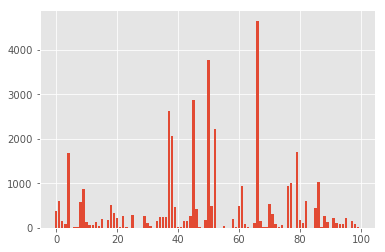

In [97]:

plt.bar( x, y)


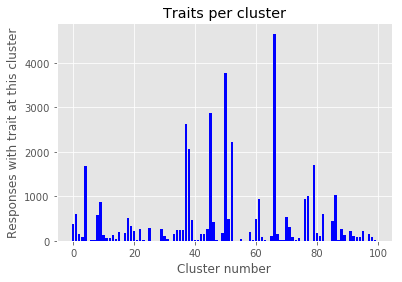

In [98]:
fig, ax = plt.subplots()

rects1 = ax.bar(x, y, color='b')
ax.set_xlabel('Cluster number')
ax.set_ylabel('Responses with trait at this cluster')
ax.set_title('Traits per cluster')



In [99]:
counts_per_cluster = np.bincount(km.labels_)

In [100]:
print (counts_per_cluster)

[  388  1056   894   887  2799    29   384    47   988  2274   439   422
   190  1054   772   482     2  2179   911   505   502   431  1038   276
   210   292   439   279    72   621   238  1093   902   211   255   810
   607  2857  4730   496   241  1376   208   890  1278  3002   282   212
   746   819  6687   511  1204     0    18   280     4   303   703    13
   606  2493   374   294   867   281 13852  3079   275   618  1547  1583
   194   236   246  1213  1894  1547    14  2565   866   882   759    56
   324   444  1305  2521   657   204   283  1252   332   435   445  1881
   600   389   429   320]


In [101]:
counts_per_cluster = list(counts_per_cluster)

In [102]:
counts_per_cluster.remove(0)

In [103]:
counts_per_cluster = np.array(counts_per_cluster)

In [104]:
y1 = y / counts_per_cluster

In [105]:
y

cluster_100
0      381
1      594
2      156
3       94
4     1689
5        0
6       24
7       11
8      588
9      864
10     121
11      72
12      54
13     136
14      41
15     202
16       2
17     178
18     503
19     325
20     220
21      16
22     269
23      26
24       1
25     278
26       0
27       0
28       5
29     267
      ... 
70     533
71     321
72      80
73      11
74      67
75       0
76     935
77     997
78       6
79    1702
80     183
81     102
82     595
83       0
84       5
85     437
86    1022
87      29
88     273
89     124
90       5
91     224
92     109
93      83
94      87
95     209
96       6
97     149
98      76
99      26
Length: 99, dtype: int64

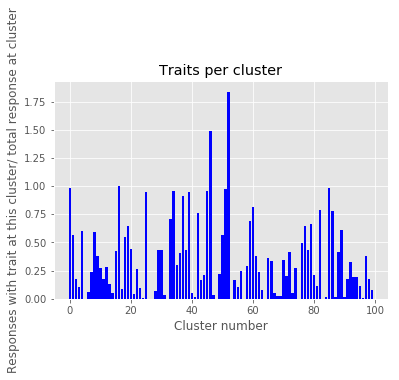

In [106]:
fig, ax = plt.subplots()

rects1 = ax.bar(x, y1, color='b')
ax.set_xlabel('Cluster number')
ax.set_ylabel('Responses with trait at this cluster/ total response at cluster')
ax.set_title('Traits per cluster')